# <font color='darkblue'>Setup</font> 

In [161]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Get Data ----------------------------------------------#

# get data from tigress - currently this is Liao's
path = '/home/jennap/projects/LRGROUP/shared_data/Merged_ARGO_WOD_GOSHIP/'
infn = 'Profiles_temp_psal_doxy.nc'

ds = xr.open_dataset(path + infn)
# print(ds.keys())

# change time variable ----------------------------------#
# set the units to be something xarray can decode
ds.time.attrs['units'] = 'days since 01-01-1800'
#re-decode the dataset
ds = xr.decode_cf(ds)

# <font color='darkblue'>Find Gradients</font> 

In [190]:
def smooth_value(value,pres, n=3) :
    mask=np.isfinite(value)
    value_finite=value[mask]

    value_sum =np.full((len(value_finite)),0)
    value_ind =np.full((len(value_finite)),0)
    
    for i in range(-int((n-1)/2),int((n-1)/2)+1):
        n_av,n_ap  = np.abs(i)*(i<0),np.abs(i)*(i>0)
        zero_av    = np.full((n_av),0)
        zero_ap    = np.full((n_ap),0)
        value_one  = np.full((len(value_sum)-n_av-n_ap),1)
        value_bool = np.concatenate((zero_av,value_one,zero_ap))
        
        value_mask = np.flip(value_bool)==1
        value_crop = value_finite[value_mask]
        
        value_conc = np.concatenate((zero_av,value_crop,zero_ap))
        
        value_sum = value_sum + value_conc
        value_ind = value_ind + value_bool
        
    value_smooth = value_sum/value_ind
    
    return value_smooth,pres[mask]

[====================================================================================================] 100%

-1

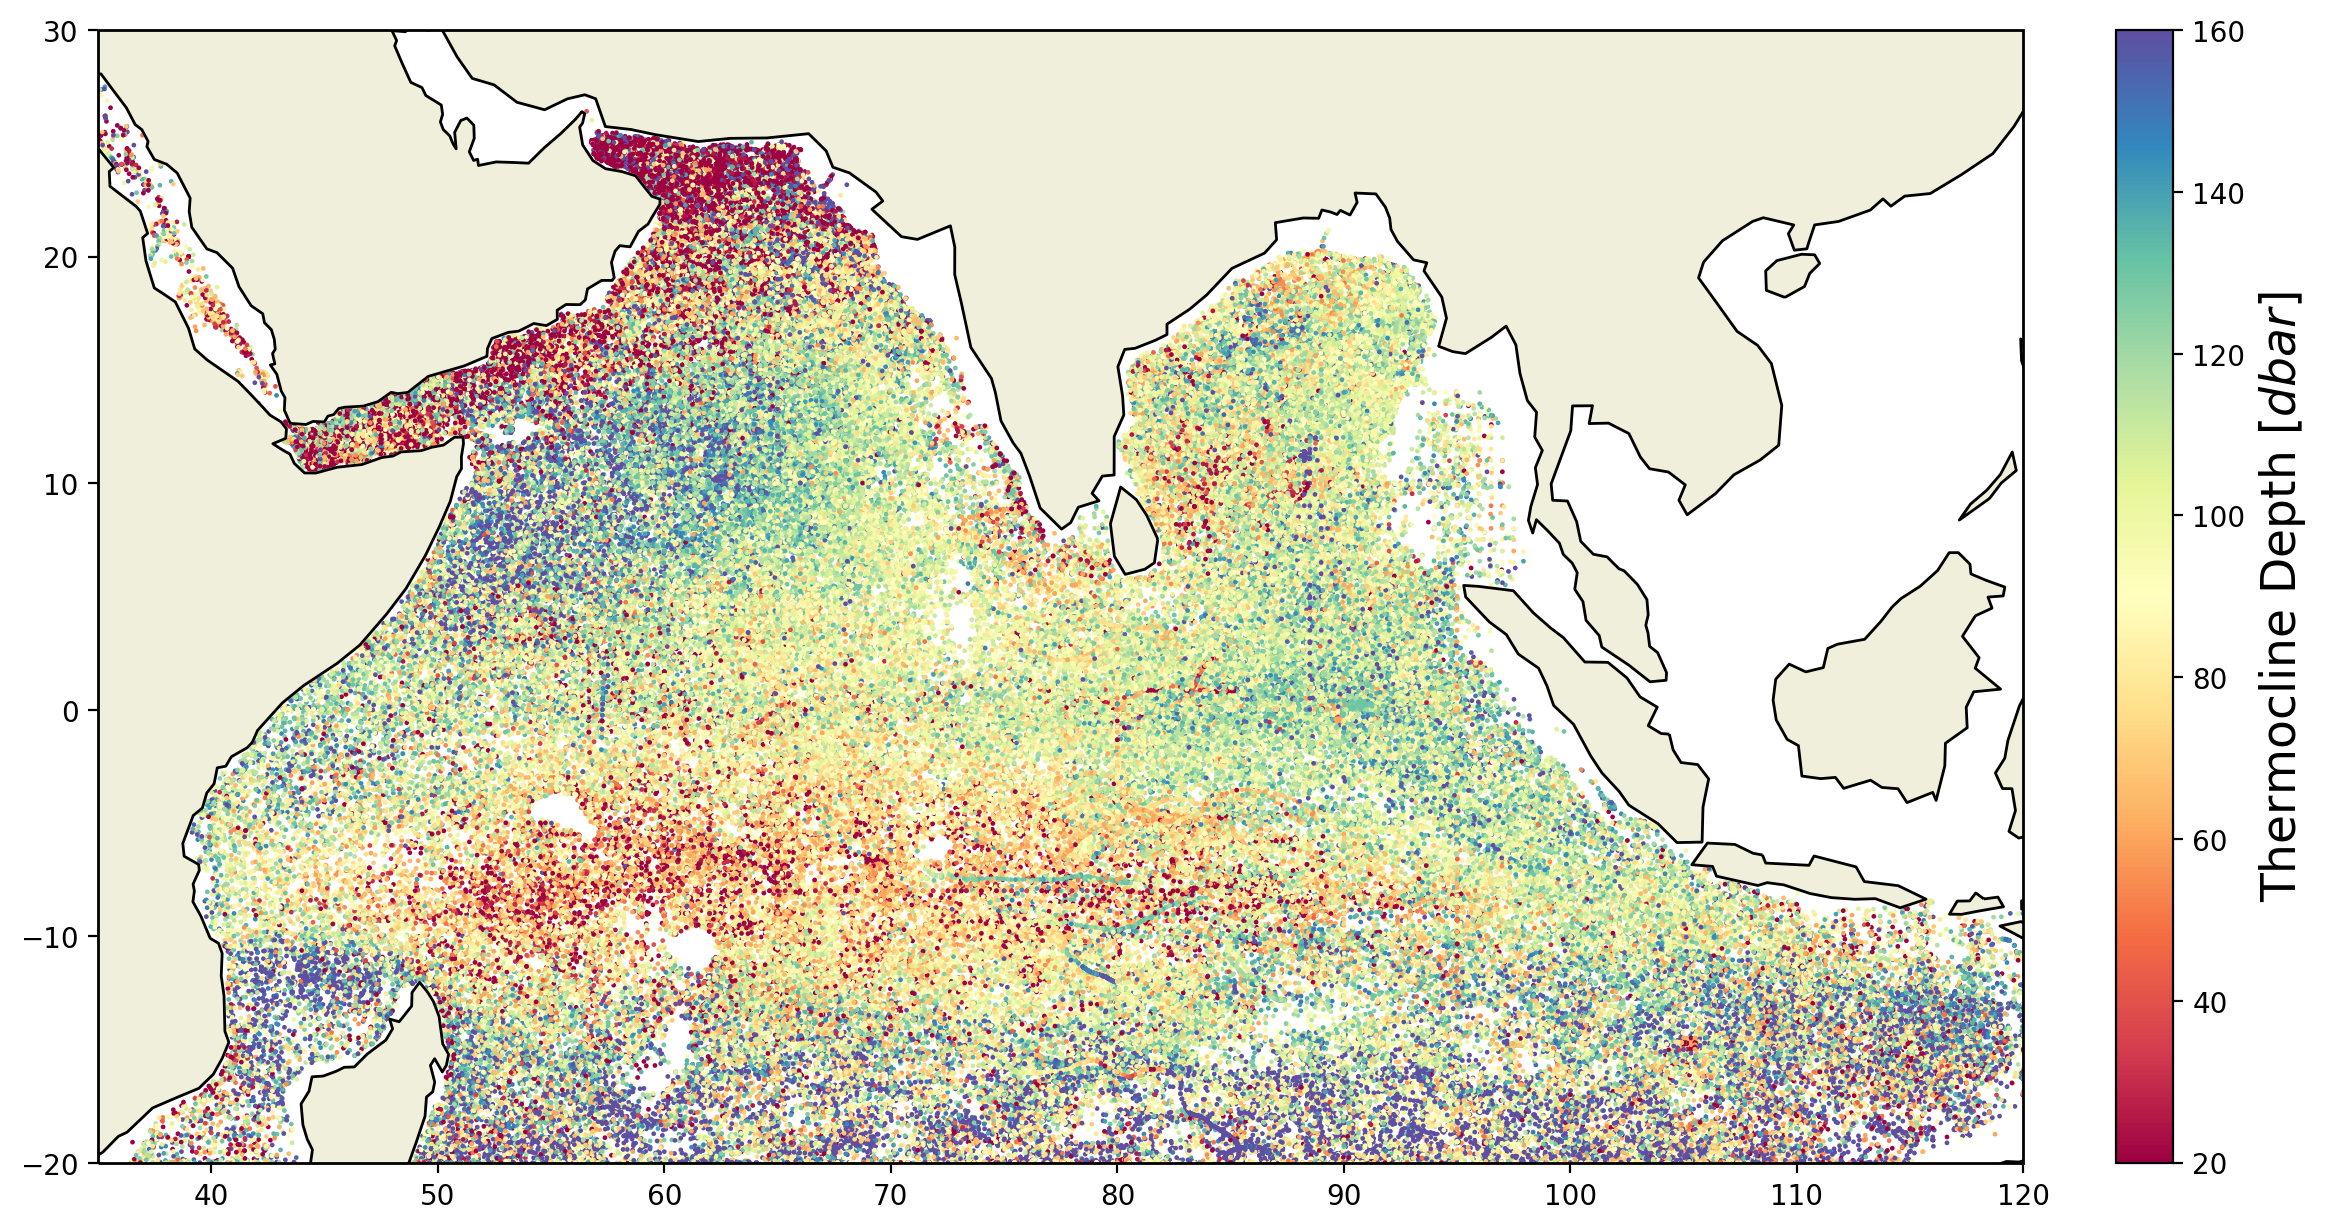

In [254]:
def progress_bar(itr,total):
    from time import sleep
    import sys
    sys.stdout.write('\r')
    
    if itr > 0:
        prev = np.round((itr-1)/total*100,2)
    else:
        prev = 0
    
    curr = np.round(itr/total*100,2)
    if (curr != prev):
        # the exact output you're looking for:
        sys.stdout.write('[%-2s] %d%%' % ('='*int(curr), curr))
        sys.stdout.flush()

        
TCD = []
OCD = []

for pr in range(ds.temp.shape[0]):
    
    progress_bar(pr,ds.temp.shape[0]-1)
    
    temp = np.array(ds.temp[pr,ds.pres<500])
    doxy = np.array(ds.doxy[pr,ds.pres<500])
    pres = np.array(ds.pres[ds.pres<500])
    
    # temp
    if np.sum(np.isfinite(temp))>10:
        
        grad_sm,pres_sm=smooth_value(np.gradient(temp),pres,n=13)
        if np.max(pres_sm)>200:
            mask  = grad_sm==np.min(grad_sm)
            thermocline = np.mean(pres_sm[mask])
            TCD.append(thermocline)
            
        else:
            TCD.append(np.nan)
    else:
        TCD.append(np.nan)
        
#     # doxy
#     if np.sum(np.isfinite(temp))>10:
#         grad_sm,pres_sm=smooth_value(np.gradient(temp),pres,n=7)
#         if np.max(pres_sm)>200:
#             mask  = grad_sm==np.min(grad_sm)
#             oxycline = np.mean(pres_sm[mask])
#             OCD.append(oxycline)
            
#         else:
#             OCD.append(np.nan)
#     else:
#         OCD.append(np.nan)

# OCD=np.array(OCD)
TCD=np.array(TCD)

# # Find centered dT/dp and dO/dp
# temp_grad = ds.temp.differentiate("pres")/ds.pres.differentiate("pres")
# doxy_grad = ds.doxy.differentiate("pres")/ds.pres.differentiate("pres")

# pres_grad = ds.pres

# #add to dataset
# ds['temp_grad'] = xr.DataArray(temp_grad,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])
# ds['doxy_grad'] = xr.DataArray(doxy_grad,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])

# # lightly smooth profiles
# # temp_grad_sm_10 = ds.temp_grad.rolling(pres_grad=13, center=True).mean()
# # doxy_grad_sm_10 = ds.doxy_grad.rolling(pres_grad=7, center=True).mean()
# temp_grad_sm_10 = smooth_value(ds.temp_grad,ds.pres_grad,n=13)
# doxy_grad_sm_10 = smooth_value(ds.doxy_grad,ds.pres_grad,n=7)

# #add to dataset
# ds['temp_grad_sm_10'] = xr.DataArray(temp_grad_sm_10,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])
# ds['doxy_grad_sm_10'] = xr.DataArray(doxy_grad_sm_10,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])

vmin=20
vmax=160
fsize=17

fig=plt.figure(figsize=(15,7.5),dpi=200)
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,zorder=3)
ax.add_feature(cfeature.LAND,zorder=2)
#ax.set_title("Raw data - Thermocline Depth",fontsize=20)
ax.set_xticks([40, 50, 60, 70, 80, 90, 100,110,120,130], crs=ccrs.PlateCarree())
ax.set_yticks([-20,-10,0,10, 20,30], crs=ccrs.PlateCarree())
ax.set_extent((35,120,-20,30),crs=ccrs.PlateCarree())
c=ax.scatter(ds.lon,ds.lat,s=0.5,vmin=vmin,vmax=vmax,c=TCD,cmap=plt.cm.Spectral)
cb=plt.colorbar(c,fraction=0.046, pad=0.04)
cb.set_label(r'Thermocline Depth [$dbar$]',size=fsize)
-1

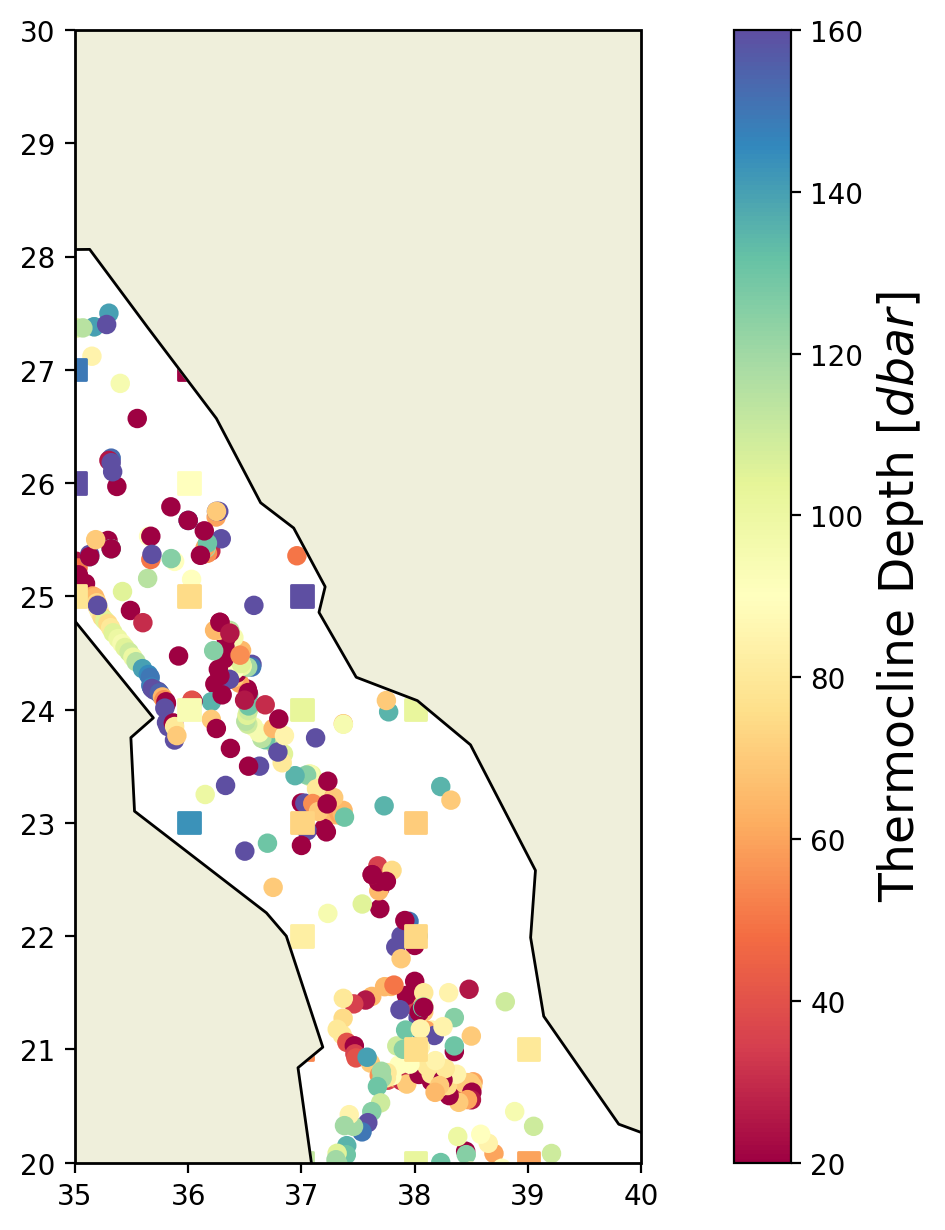

In [365]:
vmin=20
vmax=160
fsize=17

fig=plt.figure(figsize=(15,7.5),dpi=200)
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,zorder=3)
ax.add_feature(cfeature.LAND,zorder=2)
#ax.set_title("Raw data - Thermocline Depth",fontsize=20)
# ax.set_xticks([40, 50, 60, 70, 80, 90, 100,110,120,130], crs=ccrs.PlateCarree())
# ax.set_yticks([-20,-10,0,10, 20,30], crs=ccrs.PlateCarree())
ax.set_xticks([35,36,37,38,39,40], crs=ccrs.PlateCarree())
ax.set_yticks([20,21,22,23,24,25,26,27,28,29,30], crs=ccrs.PlateCarree())
ax.set_extent((35,40,20,30),crs=ccrs.PlateCarree())
c=ax.scatter(ds.lon,ds.lat,vmin=vmin,vmax=vmax,c=TCD,cmap=plt.cm.Spectral)


ax.scatter(xx.flatten(),yy.flatten(),marker='s',c=TCD_binned_ave.flatten(),s=s,cmap=plt.cm.Spectral,vmin=vmin,vmax=vmax)
cb=plt.colorbar(c,fraction=0.046, pad=0.04)
cb.set_label(r'Thermocline Depth [$dbar$]',size=fsize)


# <font color='darkblue'>Find TCD and OCD</font> 

In [ ]:
#mask the nans in the arrays so that the functions work as expected 
temp_grad = np.ma.masked_array(ds.temp_grad, np.isnan(ds.temp_grad))
doxy_grad = np.ma.masked_array(ds.doxy_grad, np.isnan(ds.doxy_grad))

temp_grad_sm_10 = np.ma.masked_array(ds.temp_grad_sm_10, np.isnan(ds.temp_grad_sm_10))
doxy_grad_sm_10 = np.ma.masked_array(ds.doxy_grad_sm_10, np.isnan(ds.doxy_grad_sm_10))

# find maximum negative gradients (min grad)
upper_temp_grad_min_ind = np.nanargmin(upper_temp_grad,1)
upper_doxy_grad_min_ind = np.nanargmin(upper_doxy_grad,1)

upper_temp_grad_sm_10_min_ind = np.nanargmin(upper_temp_grad_sm_10,1)
upper_doxy_grad_sm_10_min_ind = np.nanargmin(upper_doxy_grad_sm_10,1)

# find data above 500dbars
upper_temp_grad = temp_grad[:,pres_grad<500]
upper_doxy_grad = doxy_grad[:,pres_grad<500]

upper_temp_grad_sm_10 = temp_grad_sm_10[:,pres_grad<500]
upper_doxy_grad_sm_10 = doxy_grad_sm_10[:,pres_grad<500]

# take the pressure value at the min index 
TCD = pres_grad[upper_temp_grad_min_ind]
OCD = pres_grad[upper_doxy_grad_min_ind]

TCD_sm_10 = pres_grad[upper_temp_grad_sm_10_min_ind]
OCD_sm_10 = pres_grad[upper_doxy_grad_sm_10_min_ind]

# set places with less than 10 pts above 500dbars to nan
temp_mind_pt_ind = np.sum(np.isfinite(upper_temp_grad),1) <10
doxy_mind_pt_ind = np.sum(np.isfinite(upper_doxy_grad),1) <10

temp_mind_pt_ind_sm_10 = np.sum(np.isfinite(upper_temp_grad_sm_10),1) <10
doxy_mind_pt_ind_sm_10 = np.sum(np.isfinite(upper_doxy_grad_sm_10),1) <10

TCD = TCD.where(~np.array(temp_mind_pt_ind))
OCD = OCD.where(~np.array(doxy_mind_pt_ind))

TCD_sm_10 = TCD_sm_10.where(~np.array(temp_mind_pt_ind_sm_10))
OCD_sm_10 = OCD_sm_10.where(~np.array(doxy_mind_pt_ind_sm_10))

#add to dataset
ds['TCD'] = xr.DataArray(TCD,dims = ['prof'],coords =[ds.prof])
ds['OCD'] = xr.DataArray(OCD,dims = ['prof'],coords =[ds.prof])

ds['TCD_sm_10'] = xr.DataArray(TCD_sm_10,dims = ['prof'],coords =[ds.prof])
ds['OCD_sm_10'] = xr.DataArray(OCD_sm_10,dims = ['prof'],coords =[ds.prof])



## Scatterplots

In [ ]:
# Plotting
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits 
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.TCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.TCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('50 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.OCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.OCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('50 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')

### Binned Maps

https://stackoverflow.com/questions/40465026/groupby-bins-on-two-variables

In [363]:
def latlonbin(invar,lat,lon,date,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
            date = np.array(date)
        ))
    

    # create 1 degree bins
    latedges = np.arange(lat.min()-(binwidth/2),lat.max()+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(lon.min()-(binwidth/2),lon.max()+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

#     latmin = ds.lat.min()
#     latmax = ds.lat.max()
#     latedges = np.linspace(int(latmin)+n/2,int(latmax)+n/2,int(int(latmax)-int(latmin))/n+1)
#     lat_inds = list(range(len(latedges)-1))
    
#     lonmin = ds.lon.min()
#     lonmax = ds.lon.max()
#     lonedges = np.linspace(int(lonmin)+n/2,int(lonmax)+n/2,int(int(lonmax)-int(lonmin))/n+1)
#     lon_inds = list(range(len(lonedges)-1))
    
    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
#     df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)
        
#     # create pcolormesh lat/lon vals
    
#     # extend longitude by 2
#     lon_extend = np.zeros(lonbins.size+2)
#     # fill in internal values
#     lon_extend[1:-1] = lonbins # fill up with original values
#     # fill in extra endpoints
#     lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
#     lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
#     # calculate the midpoints
#     lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

#     # extend latitude by 2
#     lat_extend = np.zeros(latbins.size+2)
#     # fill in internal values
#     lat_extend[1:-1] = latbins
#     # fill in extra endpoints
#     lat_extend[0] = latbins[0]-np.diff(latbins)[0]
#     lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
#     # calculate the midpoints
#     lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))
    

    return(np.array(invar_binned_ave,dtype = float), 
           lonbins,latbins)



In [333]:
n = 1
latmin = ds.lat.min()
latmax = ds.lat.max()
np.linspace(int(latmin)+n/2,int(latmax)+n/2,int(int(latmax)-int(latmin))/n+1)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


array([-28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5,
       -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,
        -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,
         7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,
        16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,
        25.5,  26.5,  27.5,  28.5,  29.5])

In [346]:
latbins

array([-30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20.,
       -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,
        -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.])

In [349]:
def closest_x(x,x_range):
    down=x_range[x_range<x]
    up=x_range[x_range>x]
    if len(down)>0 and len(up)>0:
        if x-down[-1] >= up[0]-x:
            return len(down)
        if x-down[-1] < up[0]-x:
            return len(down)-1
    elif len(up)>0:
        return len(down)
    elif len(down)>0:
        return len(down)-1
    else:
        return -1
    
def grid(valeur,longitude,latitude,n=1,lonmin=35,lonmax=135,latmin=-20,latmax=30):
    if latmin<0:
        latmin=latmin-1
    if latmax<0:
        latmax=latmax-1
    lat_range=np.linspace(int(latmin)+n/2,int(latmax)+n/2,int(int(latmax)-int(latmin))/n+1)
    lon_range=np.linspace(int(lonmin)+n/2,int(lonmax)+n/2,int(int(lonmax)-int(lonmin))/n+1)
    
    grid_value=np.full((len(lon_range),len(lat_range)),np.nan)
    grid_std=np.full((len(lon_range),len(lat_range)),0)
    grid_index=np.full((len(lon_range),len(lat_range)),0)

    for val,lon,lat in zip(valeur,longitude,latitude):
        i=closest_x(lon,lon_range)
        j=closest_x(lat,lat_range)
        interv_sap= lon < lonmax+n/2 and lon > lonmin-n/2 and lat > latmin-n/2 and lat < latmax+n/2
        if i>=0 and j>=0 and interv_sap:
            if grid_index[i,j]==0 and np.isfinite(val):
                grid_index[i,j]=1
                grid_value[i,j]=val
            elif np.isfinite(val):
                grid_index[i,j]=grid_index[i,j]+1
                ind=grid_index[i,j]
                grid_value[i,j]= ((ind-1)/ind)*grid_value[i,j] + (val/ind)
    
    for val,lon,lat in zip(valeur,longitude,latitude):
        i=closest_x(lon,lon_range)
        j=closest_x(lat,lat_range)
        interv_sap= lon < lonmax+n/2 and lon > lonmin-n/2 and lat > latmin-n/2 and lat < latmax+n/2
        if i>=0 and j>=0 and np.isfinite(val) and interv_sap:
            grid_std[i,j]=grid_std[i,j]+(val-grid_value[i,j])**2
            ind=grid_index[i,j]
    
    for i in range(len(lon_range)):
        for j in range(len(lat_range)):
            if grid_index[i,j]>0:
                grid_std[i,j]=np.sqrt(grid_std[i,j]/grid_index[i,j])
    
    lon_range,lat_range=np.meshgrid(lon_range,lat_range)
    return grid_value,grid_std,grid_index,lat_range.T,lon_range.T

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


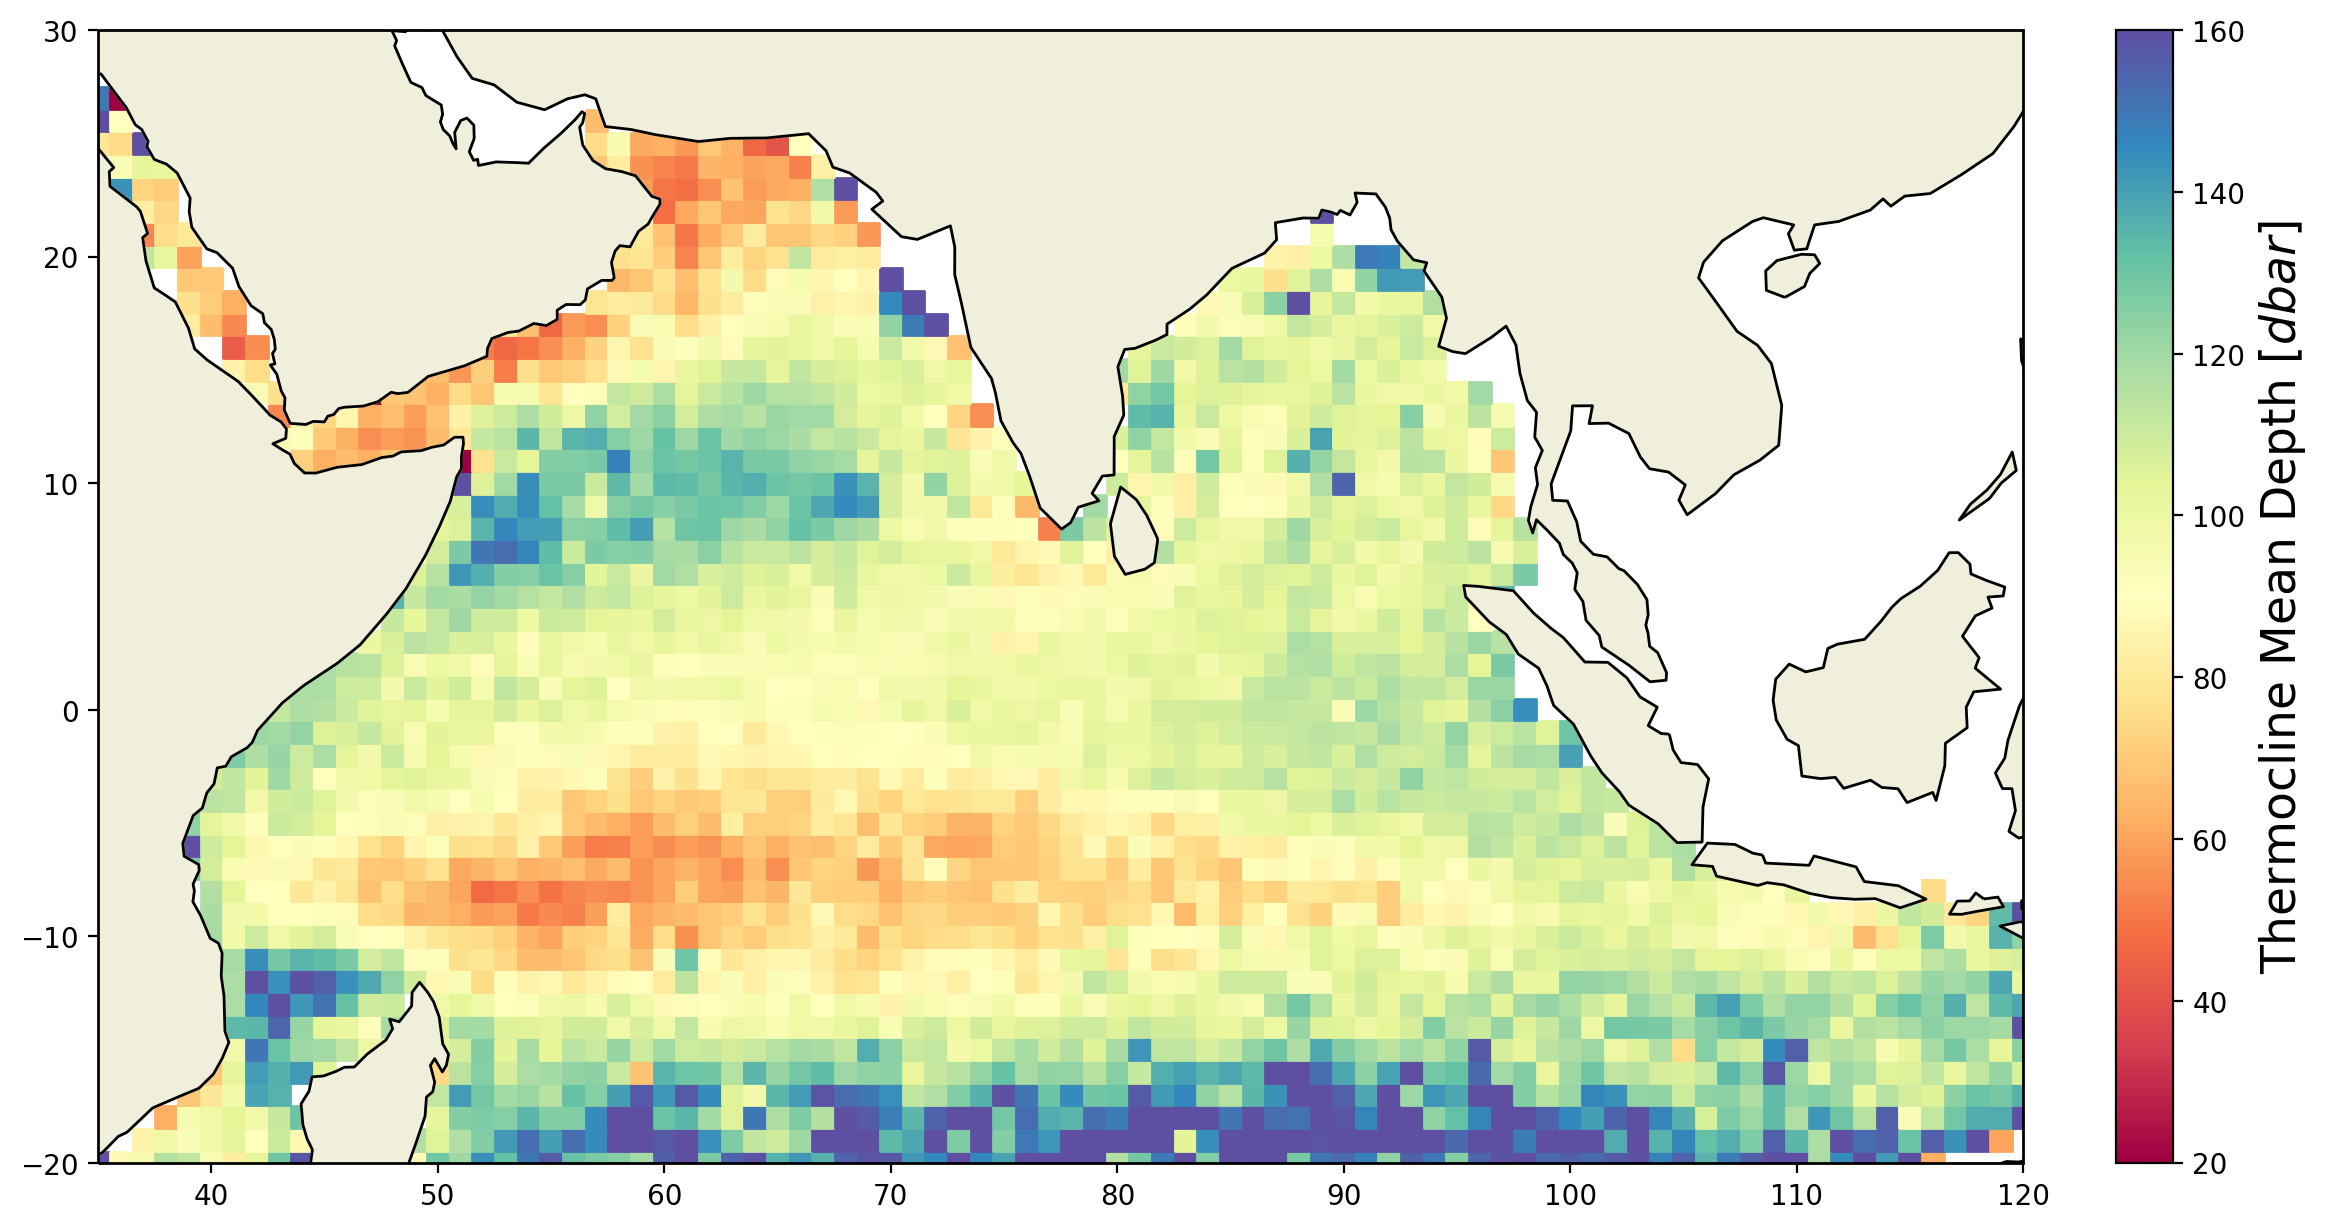

In [364]:
binwidth = 1

# TCD/OCD Binned
TCD_binned_ave, lonbins, latbins = latlonbin(TCD,ds.lat,ds.lon,ds.time,binwidth)
# OCD_binned_ave,_,_,_,_ = latlonbin(ds.OCD,ds.lat,ds.lon,ds.time,binwidth)

# TCD_sm_10_binned_ave, lonbins, latbins,lonp,latp = latlonbin(ds.TCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
# OCD_sm_10_binned_ave,_,_,_,_ = latlonbin(ds.OCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
    
# # add to dataset
# ds['TCD_binned_ave'] = xr.DataArray(TCD_binned_ave,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['OCD_binned_ave'] = xr.DataArray(OCD_binned_ave,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # add to dataset
# ds['TCD_sm_10_binned_ave'] = xr.DataArray(TCD_sm_10_binned_ave,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['OCD_sm_10_binned_ave'] = xr.DataArray(OCD_sm_10_binned_ave,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

n=1
s=60
sig=1
vmin,vmax=20,160

# moyenne,ecarttype,index,lat_range,lon_range=grid(list(TCD),list(ds.lon),list(ds.lat),n=1)
fig=plt.figure(figsize=(15,7.5),dpi=200)

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE,zorder=3)
ax.add_feature(cfeature.LAND,zorder=2)
#ax.set_title("Gridded raw data - Thermocline Depth",fontsize=20)
ax.set_xticks([40, 50, 60, 70, 80, 90, 100, 110, 120], crs=ccrs.PlateCarree())
ax.set_yticks([-20,-10, 0, 10, 20,30], crs=ccrs.PlateCarree())
ax.set_extent((35,120,-20,30),crs=ccrs.PlateCarree())
xx,yy = np.meshgrid(lonbins,latbins)
c=ax.scatter(xx.flatten(),yy.flatten(),marker='s',c=TCD_binned_ave.flatten(),s=s,cmap=plt.cm.Spectral,vmin=vmin,vmax=vmax)
# c=ax.scatter(lon_range,lat_range,marker='s',c=moyenne,s=s,cmap=plt.cm.Spectral,vmin=vmin,vmax=vmax)
cb=plt.colorbar(c,fraction=0.046, pad=0.04)
cb.set_label(r'Thermocline Mean Depth [$dbar$]',size=fsize)

In [262]:
TCD_binned_ave.shape, lonbins.shape

((60, 95), (95,))

## Plots of Binned and Vertically Smoothed

In [ ]:
# Plotting
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 10
cmax =160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,ds.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,ds.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,ds.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,ds.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## Gaussian Filtering

In [ ]:
def gaus_filter_nan(img,sigma):
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    kernel = Gaussian2DKernel(x_stddev=1)
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# add to dataset
ds['TCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds.TCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds['OCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds.OCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

## Plots of Raw, Smoothed, and Gaussian Filtered and Smoothed.

In [ ]:
# Plotting
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,ds.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,ds.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,ds.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,ds.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# Months of lowest TCD and OCD with O and T vals

In [ ]:
def latlonbin(TCD,OCD,lat,lon,date,binwidth):
    import numpy as np
    # find TCD anomaly and do correlatinos there.
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            TCD=np.array(TCD),
            OCD=np.array(OCD),
            TCD_masked=np.array(TCD),
            OCD_masked=np.array(OCD),
            lat=np.array(lat),
            lon=np.array(lon),
            date = ds.time,
            prof = np.array(ds.prof)
        ))

    # add in a column for the month
    df['month'] = pd.DatetimeIndex(df['date']).month

    # set to nans all the values where there isn't a tcd and ocd value

    ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
    df.loc[(ind),'TCD_masked']=np.nan
    df.loc[(ind),'OCD_masked']=np.nan

    # create 1 degree bins
    binwidth = 1
    # latedges = np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth)
    latedges = np.arange(ds.lat.min(),ds.lat.max(),binwidth)
    lat_inds = list(range(len(latedges)-1))

    # lonedges = np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth)
    lonedges = np.arange(ds.lon.min(),ds.lon.max(),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(ds.lat, latedges)
    df['lonedges'] = pd.cut(ds.lon, lonedges)
    df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])


    min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_OCD[:] = np.nan

    min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_OCD_month[:] = np.nan

    min_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_TCD[:] = np.nan

    min_TCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_TCD_month[:] = np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        month = np.array(group.month)


        # find month of minimum OCD
        if ~np.isnan(np.nanmin(group.OCD_masked)):
            min_OCD[i[0],j[0]] = np.nanmin(group.OCD_masked)
            ind = np.nanargmin(group.OCD_masked)
            min_OCD_month[i[0],j[0]] = month[ind]
        if ~np.isnan(np.nanmin(group.TCD_masked)): 
            min_TCD[i[0],j[0]] = np.nanmin(group.TCD_masked)
            ind = np.nanargmin(group.TCD_masked)
            min_TCD_month[i[0],j[0]] = month[ind]
            
    # create pcolormesh lat/lon vals
    
    # extend longitude by 2
    lon_extend = np.zeros(lonbins.size+2)
    # fill in internal values
    lon_extend[1:-1] = lonbins # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
    lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

    # extend latitude by 2
    lat_extend = np.zeros(latbins.size+2)
    # fill in internal values
    lat_extend[1:-1] = latbins
    # fill in extra endpoints
    lat_extend[0] = latbins[0]-np.diff(latbins)[0]
    lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

    return(np.array(min_TCD_month,dtype = float), np.array(min_OCD_month,dtype = float),
           lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)

# TCD/OCD Binned
min_TCD_month, min_OCD_month, lonbins, latbins,lonp,latp = latlonbin(ds.TCD,ds.OCD,ds.lat,ds.lon,ds.time,binwidth)

min_TCD_month_sm_10, min_OCD_month_sm_10, lonbins, latbins,lonp,latp = latlonbin(ds.TCD_sm_10,ds.OCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
   
min_TCD_month_sm_10_filt = gaus_filter_nan(min_TCD_month_sm_10,1)
min_OCD_month_sm_10_filt = gaus_filter_nan(min_OCD_month_sm_10,1)
    
# figure out why it isn't saving correctly to the ds!
    
# ds['min_OCD'] = xr.DataArray(np.array(min_OCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month'] = xr.DataArray(min_OCD_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])


# ds['min_TCD'] = xr.DataArray(np.array(min_TCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_TCD_month'] = xr.DataArray(np.array(min_TCD_month,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # add to dataset
# ds['min_TCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_TCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_OCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
# Plotting
import cmocean

def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 20
cmax = 160
bounds = [35,100,0,30]
cmap = plt.cm.RdBu_r #cmocean.cm.phase

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,8),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,min_TCD_month_sm_10,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Month of Minimum TCD')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,min_TCD_month_sm_10_filt,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,min_OCD_month_sm_10,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Month of Minimum OCD')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,min_OCD_month_sm_10_filt,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('Month of Minimum OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04,
                    ticks = np.arange(1,13))
cbar.set_ticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

## Find Correlations


In [ ]:
# # my attempt without pandas
# import itertools

# binwidth = 1
# latedges =  list(np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth))
# lonedges =  list(np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth))

# TCD_BINNED = np.zeros((len(latedges),len(lonedges)), dtype=np.ndarray)

# for i in range(len(latedges)-1):
#     for j in range(len(lonedges)-1):
# #         print(i,j)
    
#         ind = (ds.lat>= latedges[i]) & (ds.lat<=latedges[i+1]) & (ds.lon>= lonedges[j]) & (ds.lon<=lonedges[j+1])
        
#         TCD_BINNED[i,j] = np.array(ds.TCD[ind])
#         TCD_binned_ave = np.nanmean(ds.TCD[ind])

# set values to nans for the correlations



In [ ]:
# # convert to np array to work with the stats.binned stuff.
# lon = np.array(ds.lon)
# lat = np.array(ds.lat)

# # create 1 degree bins
# latedges = np.r_[ds.lat.min():ds.lat.max():1]
# lonedges = np.r_[ds.lon.min():ds.lon.max():1]

# TCD_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(TCD)], 
#                                                                  lon[~np.isnan(TCD)], TCD[~np.isnan(TCD)], 
#                                                                  'mean', bins=[latedges, lonedges])
# OCD_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(OCD)], 
#                                                                  lon[~np.isnan(OCD)], OCD[~np.isnan(OCD)], 
#                                                                  'mean', bins=[latedges, lonedges])

# TCD_sm_10_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(TCD_sm_10)], 
#                                                                  lon[~np.isnan(TCD_sm_10)], 
#                                                                  TCD_sm_10[~np.isnan(TCD_sm_10)], 
#                                                                  'mean', bins=[latedges, lonedges])

# OCD_sm_10_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(OCD_sm_10)], 
#                                                                  lon[~np.isnan(OCD_sm_10)], 
#                                                                  OCD_sm_10[~np.isnan(OCD_sm_10)], 
#                                                                  'mean', bins=[latedges, lonedges])

# lonbins = xedges[1:] - 1/2
# latbins = yedges[1:] - 1/2

# # add to dataset
# ds['lonbins'] = xr.DataArray(lonbins,dims = ['lonbins'],coords =[lonbins])
# ds['latbins'] = xr.DataArray(latbins,dims = ['latbins'],coords =[latbins])

# ds['TCD_binned'] = xr.DataArray(TCD_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_binned'] = xr.DataArray(OCD_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['TCD_sm_10_binned'] = xr.DataArray(TCD_sm_10_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_sm_10_binned'] = xr.DataArray(OCD_sm_10_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # apply a Guassian filter with st = 1 --- figure out how to deal with the coastlines later
# TCD_sm_10_binned_filtered = xr.DataArray(gaussian_filter(ds.TCD_sm_10_binned,
#                                                          sigma=1),coords = [ds.latbins,ds.lonbins])

# OCD_sm_10_binned_filtered = xr.DataArray(gaussian_filter(ds.OCD_sm_10_binned,
#                                                        sigma=1),coords = [ds.latbins,ds.lonbins])
# # add to dataset
# ds['TCD_sm_10_binned_filtered'] = xr.DataArray(TCD_sm_10_binned_filtered,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_sm_10_binned_filtered'] = xr.DataArray(OCD_sm_10_binned_filtered,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [ ]:
# # find TCD anomaly and do correlatinos there.
# # create a pandas dataframe
# df = pd.DataFrame(dict(
#         TCD=np.array(ds.TCD),
#         OCD=np.array(ds.OCD),
#         TCD_masked=np.array(ds.TCD),
#         OCD_masked=np.array(ds.OCD),
#         lat=np.array(ds.lat),
#         lon=np.array(ds.lon),
#         date = ds.time,
#         prof = np.array(ds.prof)
#     ))

# # add in a column for the month
# df['month'] = pd.DatetimeIndex(df['date']).month

# # set to nans all the values where there isn't a tcd and ocd value

# ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
# df.loc[(ind),'TCD_masked']=np.nan
# df.loc[(ind),'OCD_masked']=np.nan

# # create 1 degree bins
# binwidth = 1
# # latedges = np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth)
# latedges = np.arange(ds.lat.min(),ds.lat.max(),binwidth)
# lat_inds = list(range(len(latedges)-1))

# # lonedges = np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth)
# lonedges = np.arange(ds.lon.min(),ds.lon.max(),binwidth)
# lon_inds = list(range(len(lonedges)-1))

# latbins = latedges[1:]-(binwidth/2)
# lonbins = lonedges[1:]-(binwidth/2)

# df['latedges'] = pd.cut(ds.lat, latedges)
# df['lonedges'] = pd.cut(ds.lon, lonedges)
# df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
# df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
# df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
# grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

# TCD_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# TCD_BINNED[:] = np.nan
# OCD_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# OCD_BINNED[:] = np.nan

# TCD_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# TCD_binned_ave[:] = np.nan

# OCD_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# OCD_binned_ave[:] = np.nan

# min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_OCD[:] = np.nan

# min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_OCD_month[:] = np.nan

# min_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_TCD[:] = np.nan

# min_TCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_TCD_month[:] = np.nan

# #extract the data for each group
# for name, group in grouped:
#     i = np.array(group.latbins_ind)
#     j = np.array(group.lonbins_ind)
#     month = np.array(group.month)
    
#     TCD_BINNED[i[0],j[0]] = group.TCD
#     OCD_BINNED[i[0],j[0]] = group.OCD
    
#     TCD_binned_ave[i[0],j[0]] = np.nanmean(group.TCD)
#     OCD_binned_ave[i[0],j[0]] = np.nanmean(group.OCD)
    
#     # find month of minimum OCD
#     if ~np.isnan(np.nanmin(group.OCD_masked)):
#         min_OCD[i[0],j[0]] = np.nanmin(group.OCD_masked)
#         ind = np.nanargmin(group.OCD_masked)
#         min_OCD_month[i[0],j[0]] = month[ind]
#     if ~np.isnan(np.nanmin(group.TCD_masked)): 
#         min_TCD[i[0],j[0]] = np.nanmin(group.TCD_masked)
#         ind = np.nanargmin(group.TCD_masked)
#         min_TCD_month[i[0],j[0]] = month[ind]
    
#     # find average doxy during month of minmum OCD
    
#     # seasonal correlations
#     # used masked variables
    
# #     scipy.stats.pearsonr(x, y)[source]¶
   